# Tutorial 2: Testing for Normality and Time Series Basics

In [3]:
import numpy as np
import pandas as pd
from scipy.special import kolmogorov
from scipy.stats import kstest, norm, chi2, jarque_bera, wishart
import matplotlib.pyplot as plt

In [4]:
rng = np.random.default_rng(12345)

In [5]:
def plot_kolmogorov_dist(start, end, delta):
    x = np.arange(start, end, delta)
    # kolmogorov() returns the survival function
    cdf = pd.Series(1 - kolmogorov(x), index=x) 
    pdf = cdf.diff() / delta

    pdf.plot(label='pdf')
    cdf.plot(label='cdf')
    plt.title(f'Kolmogorov Distribution on [{start}, {end}]')
    plt.legend()
    plt.show()
    
def plot_chi2_dist(start, end, delta, df, plot_cdf=True, dist_name=None, **kwargs):
    x = np.arange(start, end, delta)
    dist = chi2(df=df)
    pdf = pd.Series(dist.pdf(x), index=x)
    cdf = pd.Series(dist.cdf(x), index=x)

    pdf.plot(label='pdf')
    if plot_cdf:
        cdf.plot(label='cdf')

    if dist_name is None:
        dist_name = rf'$\chi_{df}^2$'
    plt.title(rf'{dist_name} Distribution on [{start:.2f}, {end:.2f}]')
    plt.legend()
    plt.show()

def mahalanobis_distance(X: np.array):
    n, p = X.shape
    mu = np.mean(X, axis=0)
    S = np.cov(X, rowvar=False)
    X0 = X - mu
    d2 = np.diag(X0 @ np.linalg.solve(S, X0.T))
    return np.sqrt(d2)

## 1. Normality Test

Financial Time Series are known to be fat-tailed. To rigorously test against the normality assumption, we can use the following statistical tests:


1. Kolmogorov–Smirnov (KS) test
2. Jarque-Bera (JB) test
3. Mahalanobis Distance

### 1.1. (One-sample) KS test

Given $n$ i.i.d. random variables $X_{1:n}$, let $\hat F_n(x) = \frac{1}{n} \sum_{i=1}^{n} \mathbb{1}[X_i \le x]$ be the empirical CDF, and $F(x)$ be the theorectial CDF.

Then, the **KS Statistics** $D_n(x) := \sup_{x \in \mathbb R} |F(x) - \hat F_n(x)|$

If $F$ is continuous, then under the null hypothesis, $\sqrt{n} D_n \xrightarrow{d} K$, where $K$ is the Kolmogorov distribution.

and $ K := \sup_{t \in [0, 1]} |B(t)|$, with $B(t)$ being a Brownian Bridge over $[0, 1]$. (this line is optional and won't be tested)

Therefore, we reject the null hypothesis that $X \sim F$ at level $\alpha$ if:

$\sqrt{n} D_n > K(\alpha)$, where $K(\alpha)$ satisfies $P(K \le K(\alpha)) = 1 - \alpha$

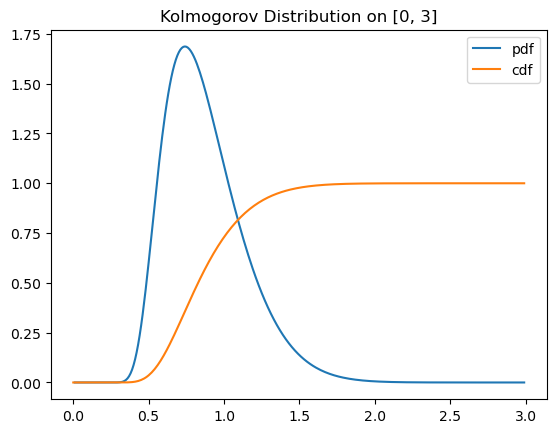

In [11]:
start, end, delta = 0, 3, 0.01
plot_kolmogorov_dist(start, end, delta)

In [12]:
alpha = 0.05
theo_cdf = "norm"
x = rng.normal(size=1000)

kstest_result = kstest(x, theo_cdf)
is_rejected = kstest_result.pvalue < 0.05
is_rejected = "DO" if is_rejected else "DO NOT"

print(f"KS-test p-value={kstest_result.pvalue:.4f}, so we {is_rejected} reject H_0 that X follows {theo_cdf} distribution.")

KS-test p-value=0.8948, so we DO NOT reject H_0 that X follows norm distribution.


### 1.2 Jarque-Bera Test

JB test is based on two quantities:

1. Sample Skewness $S = \frac{\hat \mu_3}{\hat \sigma^3} = [\frac{1}{n} \sum_{i=1}^n (x_i - \bar x)^3] / [\frac{1}{n} \sum_{i=1}^n (x_i - \bar x)^2]^{3/2}$
2. Sample Kurtosis $K = \frac{\hat \mu_4}{\hat \sigma^4} = [\frac{1}{n} \sum_{i=1}^n (x_i - \bar x)^4] / [\frac{1}{n} \sum_{i=1}^n (x_i - \bar x)^2]^{2}$

where $\hat \mu_3, \hat \mu_4$ are the $3^{rd}, 4^{th}$ sample central moments, and $\hat \sigma$ is the sample standard deviations.

The **JB Statistics** is defined as $JB_n = \frac{n}{6} [S^2 + \frac{1}{4}(K-3)^2]$

Our $H_0$ is $S=0$ and $K=3$. If $X_i$ come from the normal distribution, $JB_n \sim \chi_2^2$ as $n \to \infty$.

Therefore, we reject $H_0$ when $JB_n > \chi_2^2(a)$, where $\chi_2^2(\alpha)$ satisfies $P(\chi_2^2 \le \chi_2^2(\alpha)) = 1 - \alpha$

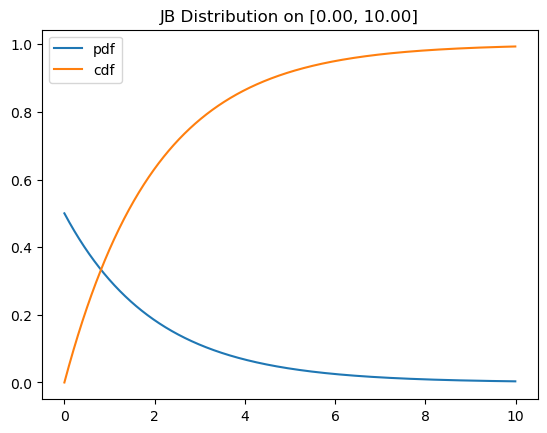

In [16]:
start, end, delta = 0, 10, 0.01
plot_chi2_dist(start, end, delta, df=2, dist_name='JB', figsize=(8, 5))

In [17]:
x = rng.normal(size=1000)
alpha = 0.05

jb_result = jarque_bera(x)
is_rejected = jb_result.pvalue < alpha
is_rejected = "DO" if is_rejected else "DO NOT"
print(f"JB-test p-value={jb_result.pvalue:.4f}, so we {is_rejected} reject H_0 that X follows normal distribution.")

JB-test p-value=0.2650, so we DO NOT reject H_0 that X follows normal distribution.


### 1.3 Mahalanobis Distance

If $\mathbf{X}_i \sim N_p(\mathbf{\mu_p}, \mathbf{\Sigma_{p \times p}})$, then:

$d_i^2 = (\mathbf x_i - \mathbf{\bar x})^T \mathbf S^{-1} (\mathbf x_i - \mathbf{\bar x}) \sim \chi^2_p$,

where $\mathbf{\bar x}, \mathbf S$ are the sample mean and covariance matrix.

Moreover, we can use $d_i^2$ to **detect outliers** using QQ-plot.

In [20]:
n, p = 1000, 4
mu = rng.normal(size=p)
C = rng.normal(size=(p, p))
S = C.T @ C
C2 = np.linalg.cholesky(S)

Z = rng.normal(size=(n, p))
X = Z @ C + mu

In the above, we simulate 1000 random normal data with dimension=4, using a random $\mu, S$

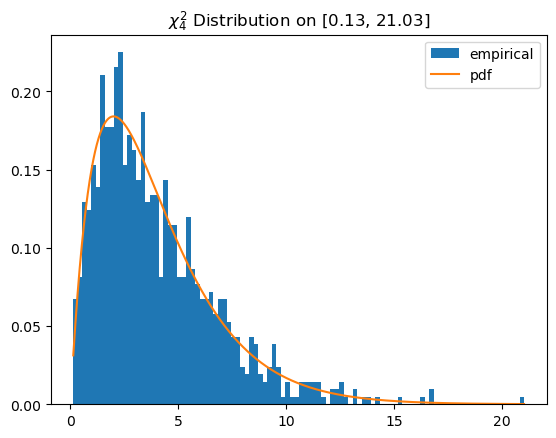

In [22]:
d = mahalanobis_distance(X)
plt.hist(d ** 2, bins=100, density=True, label='empirical');
start, end, delta = (d ** 2).min(), (d ** 2).max(), delta
plot_chi2_dist(start, end, delta, df=p, plot_cdf=False, figsize=(8, 5));

As we can see, $d_i^2$ indeed follows $\chi_p^2$ in this simulation.